In [1]:
import os, sys
sys.path.insert(0, os.environ['PROJECT_PATH'])

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

from config.resources import path_to

In [3]:
jbv_df = pd.read_csv(path_to['jbv_meta'])

In [4]:
jbv_df.dropna(inplace=True, subset=[ 'AB' ])
jbv_df.sort_values('PY', inplace=True)
time_slices = jbv_df.PY.value_counts(ascending=True).tolist()

In [5]:
import matplotlib, matplotlib.pyplot as plt


%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [6]:
jbv_df.LA.unique()

array(['English'], dtype=object)

('Number of unique author keywords in corpus:', 1748)


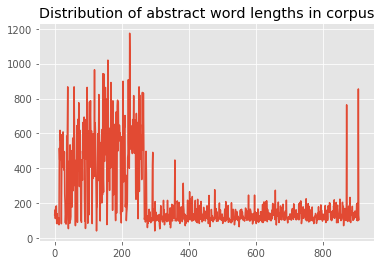

In [7]:
jbv_df['abstract_len'] = jbv_df['AB'].dropna().apply(lambda a: len(a.split()))
jbv_df['keyword_ls'] = jbv_df['DE'].dropna().apply(lambda a: a.split(';'))

plt.plot(jbv_df['abstract_len'].tolist())
plt.title('Distribution of abstract word lengths in corpus')

keyword_set = { k for _, row in jbv_df.dropna().iterrows() for k in row['keyword_ls'] }

print('Number of unique author keywords in corpus:', len(keyword_set))

In [8]:
import gensim
# pd.options.display.max_columns = 999

tokenized_abstracts = list(map(lambda a: gensim.utils.simple_preprocess(a), jbv_df.AB))

In [10]:
nb_features = 170 
custom_stop_words = ENGLISH_STOP_WORDS.union(set(['elsevier', 'rights', 'reserved'])) 
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=nb_features, stop_words=custom_stop_words)
tfidf = tfidf_vectorizer.fit_transform(jbv_df.AB)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Created %d X %d document-term matrix" % (tfidf.shape[0], tfidf.shape[1]))
print("Vocabulary has %d distinct terms" % len(tfidf_feature_names))

Created 910 X 170 document-term matrix
Vocabulary has 170 distinct terms


In [11]:
w2v_model = gensim.models.Word2Vec(tokenized_abstracts, size=500, min_count=10, sg=1)

In [12]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
# print(w2v_model.wv.vocab)

Model has 2252 terms


In [13]:
w2v_model.save("w2v-model.bin")

In [14]:
import pdb

def calculate_coherence( w2v_model, term_rankings ):
    global non_vocab_words
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try:
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]))
            except KeyError:
                pair_scores.append(0)
                non_vocab_words |= { item for item in pair if item not in w2v_model.wv.vocab }
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [15]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [16]:
from __future__ import print_function
from sklearn.decomposition import NMF

kmin, kmax = 3, 50 
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k, end='\r', )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

In [17]:
from itertools import combinations
k_values = []
coherences = []
non_vocab_words = set()
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( tfidf_feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ), end='\r', )

print(non_vocab_words)

set([u'entrepreneurship'])


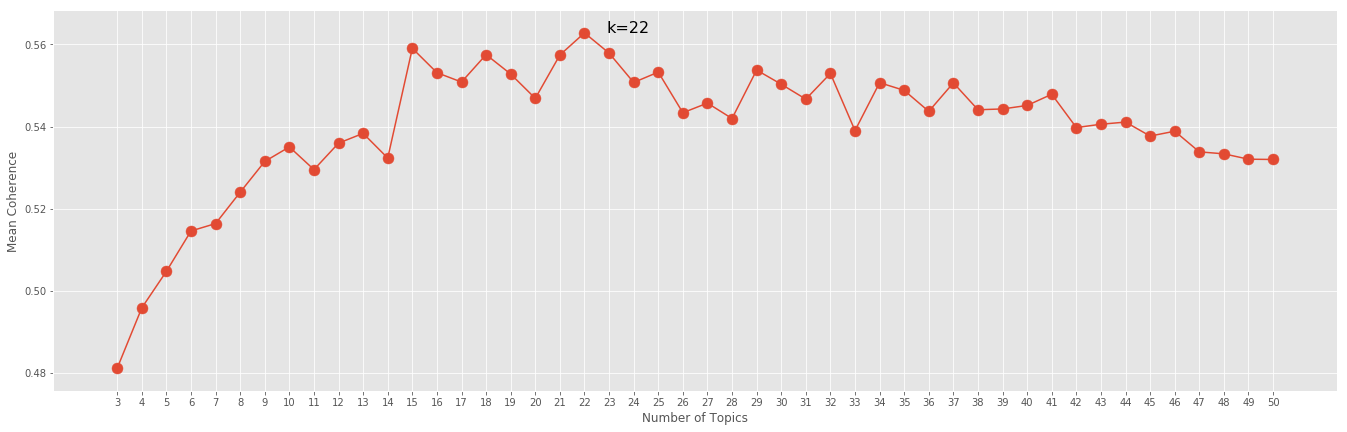

In [18]:
fig = plt.figure(figsize=(23,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [19]:
k = best_k 
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [20]:
with open(os.path.join('..', 'data', 'interim', 'topic_models', 'jbv', 'tm_{}_topics.txt'.format(k)), 'wb') as f:
    for topic_index in range(k):
        descriptor = get_descriptor( tfidf_feature_names, H, topic_index, 10 )
        str_descriptor = ", ".join( descriptor )
        print("Topic %02d: %s" % ( topic_index+1, str_descriptor ))
        print("Topic %02d: %s" % ( topic_index+1, str_descriptor ), file=f)

Topic 01: business, businesses, small, women, owners, start, study, differences, opportunities, successful
Topic 02: entrepreneurship, article, economic, research, context, activities, perspective, individuals, literature, study
Topic 03: venture, capitalists, value, entrepreneur, ventures, corporate, investment, use, capital, success
Topic 04: entrepreneurs, experience, decisions, differences, sample, develop, work, research, greater, likely
Topic 05: family, relationships, level, control, owners, creation, businesses, financing, support, theory
Topic 06: new, ventures, team, venture, survival, management, creation, start, industry, activities
Topic 07: entrepreneurial, entrepreneur, opportunities, opportunity, activity, process, individual, behavior, creation, environment
Topic 08: self, employment, individuals, women, influence, effects, relationship, high, related, level
Topic 09: social, founders, processes, impact, paper, perspective, develop, opportunity, success, role
Topic 10: